 # Import Necessary Packages and Define Helper Functions

In [1]:
#import the python scientific suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab
import statsmodels

from textblob import TextBlob

import statsmodels.api as sm

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from collections import defaultdict

In [3]:
# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
#plot figures inline in Jupyter notebooks
%matplotlib inline 

#use seaborn for plotting
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

In [432]:
def WordCount(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count

def WordFreq(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count/len(corpus.split())

def Polarity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.polarity

def Subjectivity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.subjectivity

#define some helper functions 
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

def RollingGaussianMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
            w = scipy.stats.norm.pdf((df[x] - bc)/(eps))
            if sum(w) != 0.0:
                rolling.append((bc, np.average(df[y], weights = w))) #take the mean and add it to the stack
            else:
                rolling.append((bc, np.average(df[y])))
    return(pd.DataFrame(rolling).rename(columns = {0: 'x', 1: 'y'}))

def BootstrapDataframe(df):
    resample_i = np.floor(np.random.rand(len(df))*len(df)).astype(int)
    return(df.iloc[resample_i])

 # Reading in Data Files

In [5]:
#read in the data from the files
file_dir = '~/jac_project/yz_data/' #replace this with the path to your data files

f = {'R': 'R_review_stat.csv', 'T': 'T_review_text.csv', 'N': 'N_neighborhood.csv',\
    'B': 'B_business.csv', 'U': 'U_user.csv'}

d = defaultdict() #initialize an empty dictionary to hold the dataframes

for fi in f: #for each file in the dictinary of files
    d[fi] = pd.read_csv(file_dir + f[fi]) #read in the files and hold them in the dataframe dictionary

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
print(d.keys()) #the list of files in the data dictionary

['R', 'B', 'U', 'T', 'N']


The object 'd' is our data dictionary. It contains five dataframes that are the entirety of the combined yelp and zillow datasets. For example, let's access the review statistics:

In [167]:
d['R'].head()

,Unnamed: 0,review_id,words,sentences,ease,grade,dale_chall,stars,business_id,z_hood,latest_zhvi,latest_sqft,lat,lon,bbox_area,polarity,subjectivity,year,user_id
0,0,6ZWmWypGMdnwwavY8ykXlg,197,13,73.17,6.8,6.62,4,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.260963,0.527941,2009.624658,iTmWHtltCtk0Gm55AOxrUA
1,1,3m6vLe955opYMSrTrlLIKw,385,25,90.09,4.4,6.10,2,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.009410,0.485827,2011.197260,JEvkfVPf_DuhX-ntE5L6bQ
2,2,MkHaKWwZ_OngdUsMt_xAqg,55,4,92.12,3.6,7.15,2,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.190000,0.580000,2011.438356,QOdrDkYXhqA8jtPzfpugWQ
3,3,gB-kzO-Jg_u2p7Cmf9xG_w,206,12,79.60,6.4,6.70,4,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.324351,0.606169,2011.586301,qPGLUQUG43b3aBZKDUBlMw
4,4,cCh6xPIcV6P2ben4bCsq7Q,208,9,65.05,9.9,8.19,3,uI0LvTXFACid1308KFO5ew,343635,NaN,NaN,40.392222,-79.947974,5.378061,0.209776,0.511859,2011.679452,lJsCDFtnR2-AMhDdWtCRug


# Filtering Data

The first operation we will perform is the filtration of the data, to only include certain neighborhoods, businesses, and users. We usually want to apply filters to remove users and businesses with a small number of reviews. 

In [8]:
#begin filtration of data based on multiple criteria
min_reviews_per_business = 10
min_reviews_per_user = 1
min_business_per_neighborhood = 20

#perform the filtration by updating the dataframes
d['B'] = d['B'][(d['B']['review_count'] >= min_reviews_per_business)]
d['U'] = d['U'][(d['U']['n_reviews'] >= min_reviews_per_user)]
d['N'] = d['N'][(d['N']['n'] >= min_business_per_neighborhood)]

print(len(d['N']))
print(len(d['U']))
print(len(d['B']))

192
552338
19414


In the next cell, we will use the TopChains helper function that I have made to create a list of all businesses with more than 35 stores in the database.

In [7]:
min_stores_per_chain = 35
#list of all of the chains with over a certain number of reviews
top_chains = TopChains(d['B'], min_stores_per_chain) 
print(top_chains)

['Starbucks', 'Subway', "McDonald's", 'Walgreens', 'Taco Bell', 'Pizza Hut', 'The UPS Store', "Wendy's", 'Burger King', 'Bank of America', 'Wells Fargo Bank', 'Circle K', 'Great Clips', "Domino's Pizza", 'Panda Express', "Dunkin' Donuts", 'Chase Bank', 'Supercuts', 'Chipotle Mexican Grill', 'Jiffy Lube', 'US Post Office', 'QuikTrip', "Jimmy John's", "Papa John's Pizza", 'KFC', 'Enterprise Rent-A-Car', 'Dairy Queen', 'Cvs Pharmacy', 'Jack in the Box', 'FedEx Office Print & Ship Center', 'T-Mobile', "Denny's", "Arby's"]


 # Merging and Filtering Dataframes
 
 In order to create a dataset where all three filters are applied, we need to perform a series of merges on neighborhood and user identifiers. In the next cell, we will merge the N and B dataframes, so that only businesses in neighborhoods with greater than 20 business will be included in the B dataframe. We will call this dataframe FB for 'filtered businesses'. we compare the lengths of the two dataframes to see the effect of the filter.

In [12]:
d['FB'] = pd.merge(d['N'][['z_hood']], d['B'], on = 'z_hood') #create a new dataframe in the data dictionary
print('Before Neighborhood filter: ' + str(len(d['B'])))
print('After Neighborhood filter: ' + str(len(d['FB'])))

Before Neighborhood filter: 38599
After Neighborhood filter: 37074


We can apply multiple filters at once. In this next cell, we will create a dataframe of businesses in neighborhoods with over 20 businesses, that are also in our list of top chains. Because we are testing for list inclusion in a list we use the .isin() function, instead of performing a merge.

In [13]:
d['FFB'] = d['FB'][d['FB']['name'].isin(top_chains)] #filter to just the top chains
print('Before Chain filter: ' + str(len(d['FB'])))
print('After Chain filter: ' + str(len(d['FFB'])))

Before Chain filter: 37074
After Chain filter: 2242


We can always see a list of all of the dataframes in our data dictionary:

In [14]:
print(d.keys())

['B', 'N', 'FB', 'R', 'U', 'T', 'FFB']


 # Comparing Distributions
 
 In the next cell, we will take our dataframe of chains and compare the disribution of star ratings for each chain. We can create a visualization using seaborn's built in boxplot function. First, let's sort the chains according the mean yelp stars that their stores recieve. I have created a helper function called OrderName that will list our chains in order.

In [13]:
#sort by mean stars
print(OrderName(d['FFB'], 'name', 'mean_stars'))
print('\n')
#sort by number of reviews
print(OrderName(d['FFB'], 'name', 'review_count'))

['KFC', 'Pizza Hut', "McDonald's", 'Burger King', "Wendy's", 'Bank of America', 'US Post Office', "Papa John's Pizza", 'Jack in the Box', 'Cvs Pharmacy', 'Circle K', "Denny's", 'T-Mobile', 'Panda Express', 'Taco Bell', "Dunkin' Donuts", 'Dairy Queen', "Arby's", "Jimmy John's", 'Walgreens', 'Wells Fargo Bank', 'Subway', "Domino's Pizza", 'FedEx Office Print & Ship Center', 'The UPS Store', 'Chase Bank', 'Great Clips', 'Chipotle Mexican Grill', 'Starbucks', 'Supercuts', 'Jiffy Lube', 'Enterprise Rent-A-Car', 'QuikTrip']


['Chase Bank', 'Circle K', 'Wells Fargo Bank', 'T-Mobile', 'Subway', 'Bank of America', 'Supercuts', 'Jack in the Box', "Arby's", 'The UPS Store', 'Cvs Pharmacy', 'Burger King', 'Great Clips', 'QuikTrip', 'Taco Bell', 'Walgreens', "Papa John's Pizza", 'Pizza Hut', 'FedEx Office Print & Ship Center', 'KFC', "Wendy's", "McDonald's", "Domino's Pizza", 'Panda Express', 'Dairy Queen', 'Enterprise Rent-A-Car', 'US Post Office', 'Jiffy Lube', 'Starbucks', "Dunkin' Donuts", "De

Now, we can visualize the rating distribution of each chain using seaborn, plotting them in order from lowest mean stars to highest mean stars.

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


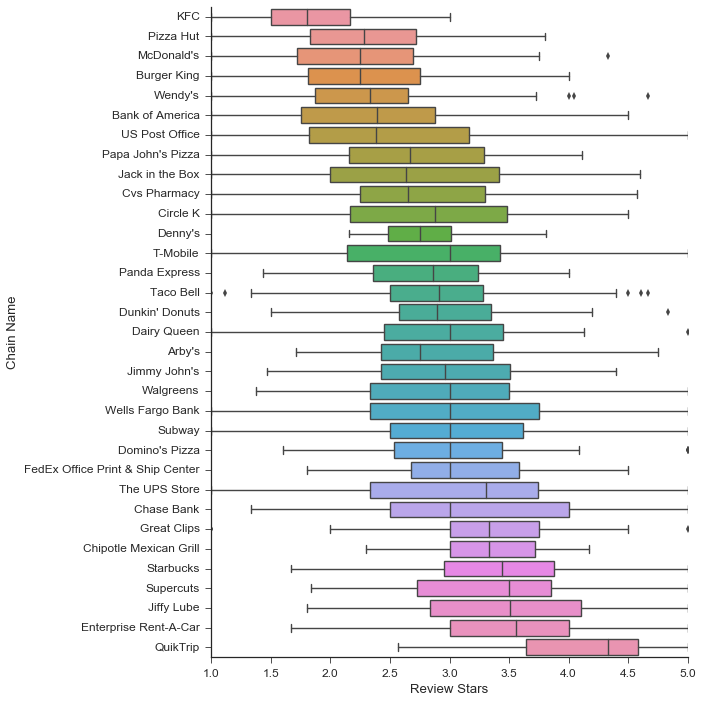

In [14]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0) #set figure parameters
sns.boxplot(data = d['FFB'], x = 'mean_stars', y = 'name', order = OrderName(d['FFB'], 'name', 'mean_stars'))
plt.xlabel('Review Stars')
plt.ylabel('Chain Name')
sns.despine()
plt.savefig('chain_stars.png', dpi = 300, fmt = 'png')
pylab.rcParams['figure.figsize'] = (6.0, 4.0) #reset figure parameters

In this next cell, we will learn how to loop through individual users, businesses, or neighborhoods. In this case we will loop through individual businesses. For each business, we will create a temporary dataframe in the loop, containing the review statistics for that business

 # Looping Through Businesses or Users
 
 Sometimes, we would like to perform a complex computation on all of the reviews pertaining to a certain neighborhood, business, or user. The next cell shows us how to select reviews corresponding to unique neighborhoods, businesses, or users.

In [15]:
for ids in np.unique(d['B']['business_id'])[0:10]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    
r.head() #let's see some of the review stats of this particular business: notice how all of the business_id are the same

,Unnamed: 0,review_id,words,sentences,ease,grade,dale_chall,stars,business_id,z_hood,latest_zhvi,latest_sqft,lat,lon,bbox_area,polarity,subjectivity,year,user_id
910023,910023,qoDP0T3iT3f98hdzOO5ARw,82,6,66.74,7.2,7.55,5,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.181593,0.542766,2013.208219,JG4BZ6PWmhB3XHgpRKaicQ
910024,910024,K4ZZINk_QMXsQQOqge9Sgw,179,10,79.60,6.4,7.04,3,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.232818,0.470280,2013.210959,ts7EG6Zv2zdMDg29nyqGfA
910025,910025,o8nKXEuFxCKLN1o7dNjlTA,93,5,87.05,5.6,6.74,4,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.207744,0.569024,2013.213699,wyukT5LzQ5CQJ1KMVuojIQ
910026,910026,CvM1tXAsVqnmQEYdXOSLag,423,21,76.56,7.6,7.69,4,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.135623,0.458455,2013.213699,3Kn23qXbgPFmtV-CbHPJ2A
910027,910027,LxZMMG2kRXzyw2up0Seh-A,320,24,75.20,6.0,7.88,5,--pOlFxITWnhzc7SHSIP0A,275101,471600.0,199.0,35.165215,-80.797661,1.385601,0.298242,0.605697,2013.219178,A6bPFcUjuuayRBoyybedDQ


 # Review Trend Computation

In the next cells, we will compute the trend of reviews over time in a random neighborhood. We will show a scatter plot of the review stars as a function of time.

Number of Reviews: 27338


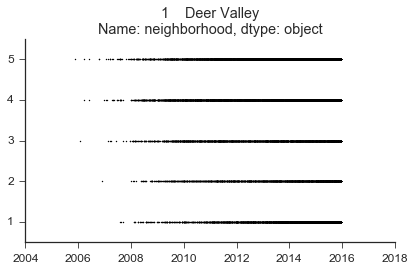

In [16]:
for ids in np.unique(d['N']['z_hood'])[0:1]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print('Number of Reviews: ' + str(len(r)))
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    sns.despine()

This shows that there were over 27,000 reviews in this neighborhood. This graph is a not easy to understand. It is hard to see how the distribution changes as a function of time. For this reason, I've created a helper function called RollingGaussianMean, which is a gaussian kernel smoother:

27338


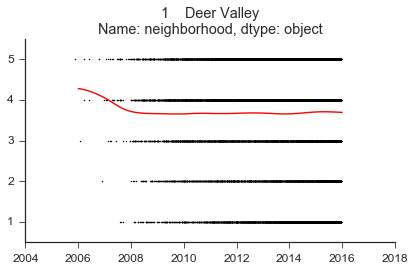

In [17]:
for ids in np.unique(d['N']['z_hood'])[0:1]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    plt.plot(gm['x'], gm['y'], c = 'red')
    sns.despine()

Looks like the mean is static as a function of time after the year 2008. Note that we can perform this analysis for all of the neighborhoods by looping through them.

1758
5516
38566
5563


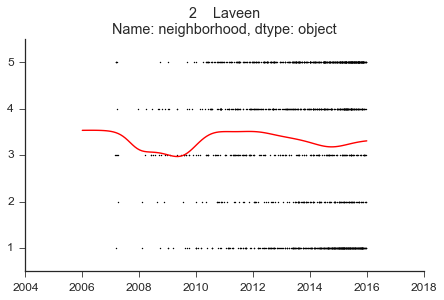

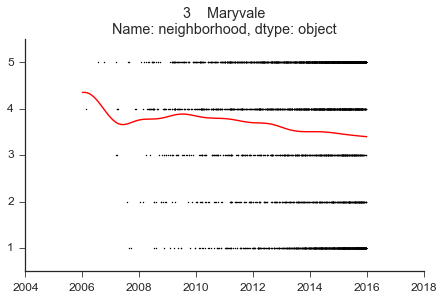

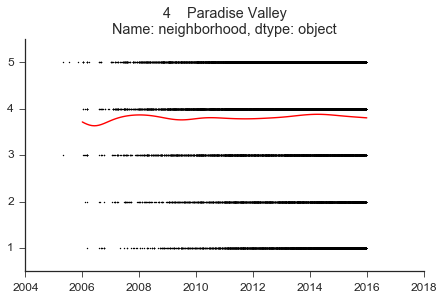

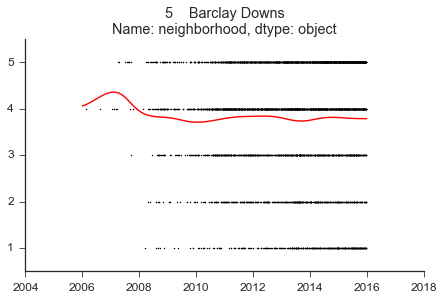

In [17]:
for ids in np.unique(d['N']['z_hood'])[1:5]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    plt.plot(gm['x'], gm['y'], c = 'red')
    sns.despine()

Let's make a data map. In the next cell, we will learn how to plot all of the businesses in one neighborhood.

 # Map Creation

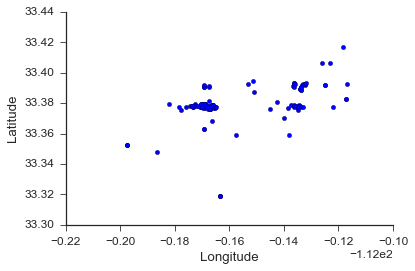

In [19]:
for ids in np.unique(d['N']['z_hood'])[1:2]: #for the unique business IDs 
    b = d['B'][d['B']['z_hood'] == ids]
    plt.scatter(b['longitude'], b['latitude'])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.despine()

When looking at data maps, it can be useful to encode a variable in the color axis of each point. In these next maps, the color of the point corresponds to the mean star rating of the business, while the size corresponds to the number of reviews that a business has.

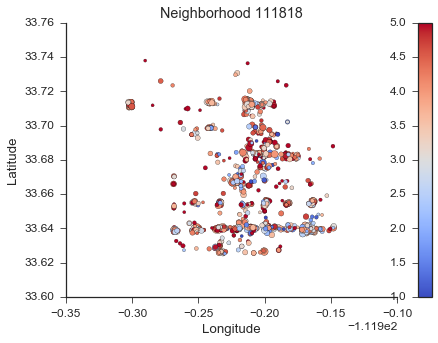

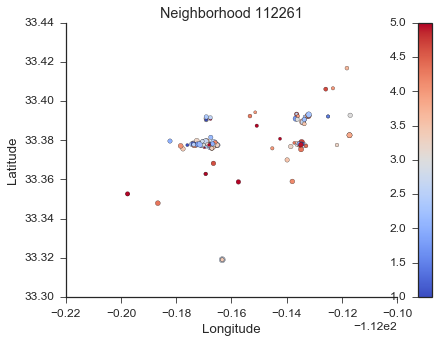

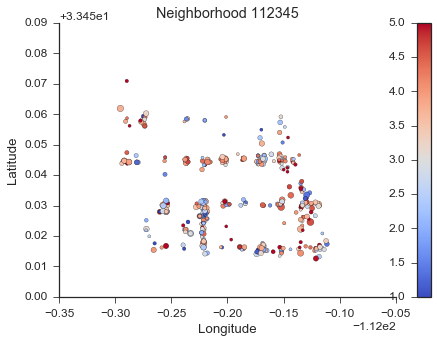

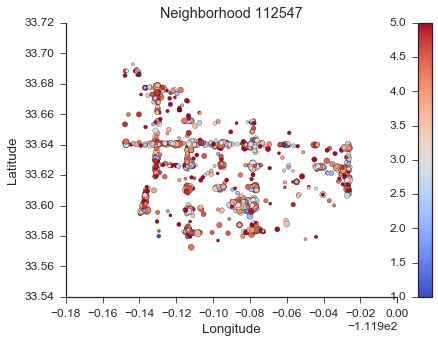

In [20]:
pylab.rcParams['figure.figsize'] = (7.0, 5.0) #use a bigger figure size for this data map
for ids in np.unique(d['N']['z_hood'])[0:4]: #for the unique business IDs 
    b = d['B'][d['B']['z_hood'] == ids]
    plt.figure()
    plt.title('Neighborhood ' + str(list(b['z_hood'])[0]))
    plt.scatter(b['longitude'], b['latitude'], c = b['mean_stars'], cmap = 'coolwarm', s = np.log10(b['review_count'])*20.0)
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.despine()

 # Review Corpus Comparison
 
 We would like to compare the set of reviews with certain keywords to those which do not contain these certain keywords. To start we will combine the review text and the review stats data. 

In [21]:
d['RT'] = pd.merge(d['R'], d['T'], on = 'review_id') #merge the review text and stats

In [22]:
d['RT'].head()

,Unnamed: 0_x,review_id,words,sentences,ease,grade,dale_chall,stars,business_id,z_hood,...,latest_sqft,lat,lon,bbox_area,polarity,subjectivity,year,user_id,Unnamed: 0_y,text
0,0,6ZWmWypGMdnwwavY8ykXlg,197,13,73.17,6.8,6.62,4,uI0LvTXFACid1308KFO5ew,343635,...,NaN,40.392222,-79.947974,5.378061,0.260963,0.527941,2009.624658,iTmWHtltCtk0Gm55AOxrUA,800,I'm not into waterparks as much as I am into a...
1,1,3m6vLe955opYMSrTrlLIKw,385,25,90.09,4.4,6.10,2,uI0LvTXFACid1308KFO5ew,343635,...,NaN,40.392222,-79.947974,5.378061,0.009410,0.485827,2011.197260,JEvkfVPf_DuhX-ntE5L6bQ,801,The evites are in the mail for the 2 for $99 s...
2,2,MkHaKWwZ_OngdUsMt_xAqg,55,4,92.12,3.6,7.15,2,uI0LvTXFACid1308KFO5ew,343635,...,NaN,40.392222,-79.947974,5.378061,0.190000,0.580000,2011.438356,QOdrDkYXhqA8jtPzfpugWQ,802,"It's fun, but not as fun as Kennywood. The boa..."
3,3,gB-kzO-Jg_u2p7Cmf9xG_w,206,12,79.60,6.4,6.70,4,uI0LvTXFACid1308KFO5ew,343635,...,NaN,40.392222,-79.947974,5.378061,0.324351,0.606169,2011.586301,qPGLUQUG43b3aBZKDUBlMw,803,"How many times do you get to fall at 70mph, we..."
4,4,cCh6xPIcV6P2ben4bCsq7Q,208,9,65.05,9.9,8.19,3,uI0LvTXFACid1308KFO5ew,343635,...,NaN,40.392222,-79.947974,5.378061,0.209776,0.511859,2011.679452,lJsCDFtnR2-AMhDdWtCRug,804,Sandcastle is a mixed bag for the kiddos. On ...


We will then use the WordCount and WordFreq helper functions to append a column to the dataframe containing the frequency and count of the keyword. This operation can take up to a minute to perform for each set of keywords, because the program loops through over 1 million reviews.

In [23]:
keyword = ['great'] #input list of keywords

d['RT']['kw_count'] =  d['RT']['text'].apply(WordCount, args = (keyword,)) #add word count column
d['RT']['kw_freq'] =  d['RT']['text'].apply(WordFreq, args = (keyword,)) #add word frequency column
d['RT']['kw'] = str(keyword)

d['WI'] = d['RT'][d['RT']['kw_count'] > 0] #review with keywords
d['WO']  = d['RT'][d['RT']['kw_count'] == 0] #review without keywords

print(len(d['WI'])) #print how many reviews contain the keywords
print((len(d['WI'])/len(d['WO']))*100.0) #print what percentage of reviews contain one of the keywords

305594
39.3033296593


We can see the added columns 'kw_count', 'kw_freq', and 'kw':

In [24]:
d['RT'][['review_id','kw_count','kw_freq', 'kw']].head()

,review_id,kw_count,kw_freq,kw
0,6ZWmWypGMdnwwavY8ykXlg,1,0.005076,['great']
1,3m6vLe955opYMSrTrlLIKw,0,0.000000,['great']
2,MkHaKWwZ_OngdUsMt_xAqg,0,0.000000,['great']
3,gB-kzO-Jg_u2p7Cmf9xG_w,1,0.004854,['great']
4,cCh6xPIcV6P2ben4bCsq7Q,0,0.000000,['great']


We will again use the helper function RollingGaussian mean to describe trends in the reviews.

In [25]:
#compute rolling gaussian means
rdf = RollingGaussianMean(d['RT'], 'latest_zhvi', 'kw_freq', np.linspace(0,1000000,101), 20000.0)
tdf = RollingGaussianMean(d['WI'], 'year', 'kw_freq', np.linspace(2006,2016,120), 0.5)
sdf = RollingGaussianMean(d['WI'], 'latest_zhvi', 'stars', np.linspace(0,1000000,101), 20000.0)

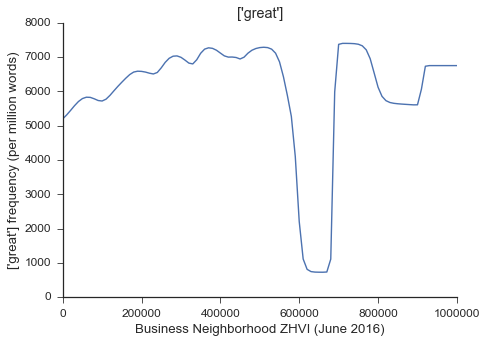

In [26]:
plt.figure()
plt.title(str(keyword))
plt.plot(rdf['x'],rdf['y']*1000000)
plt.xlim(0,1000000)
plt.ylim(0,)
plt.ylabel(str(keyword) +' frequency (per million words)')
plt.xlabel('Business Neighborhood ZHVI (June 2016)')
sns.despine()

We can see that the frequency of the word 'great' increases until the neighborhood home value is greater than 600K. The sparsity of data at high neighborhood home values calls the observed trend into question. The frequency of the word great has been on the rise: 

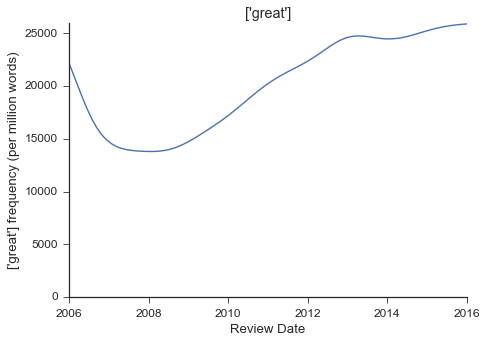

In [27]:
plt.figure()
plt.title(str(keyword))
plt.plot(tdf['x'],tdf['y']*1000000)
plt.xlim(2006,2016)
plt.ylim(0,)
plt.ylabel(str(keyword) +' frequency (per million words)')
plt.xlabel('Review Date')
sns.despine()

In this next plot, we can see that the mean stars for reviews countaining 'great' is constant as a function of ZHVI. 

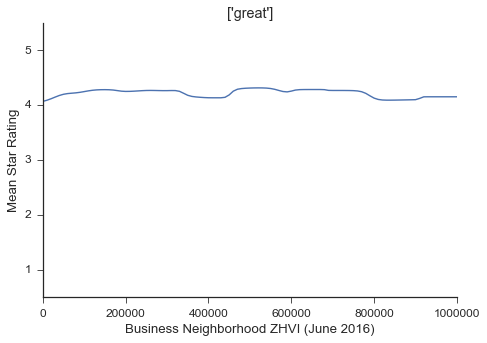

In [28]:
plt.figure()
plt.title(str(keyword))
plt.plot(sdf['x'],sdf['y'])
plt.ylabel('Mean Star Rating')
plt.ylim(0.5,5.5)
plt.xlabel('Business Neighborhood ZHVI (June 2016)')
sns.despine()

In the next cell, we can see how the presence of the keywords in the list affects the rating star assigment. Predictably, the set of reviews containing 'great' has a higher frequency of 4 and 5 star reviews than the set of all reviews.

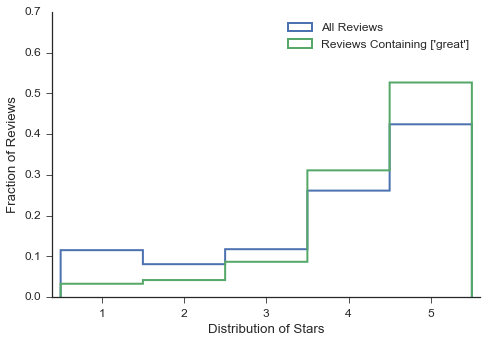

In [29]:
plt.figure()
plt.hist(d['RT']['stars'], range = [0.5,5.5], bins = 5, histtype = 'step', lw = 2, normed = True, label = 'All Reviews')
plt.hist(d['WI']['stars'], range = [0.5,5.5], bins = 5, histtype = 'step', lw = 2, normed = True,\
        label = 'Reviews Containing ' + str(keyword))
plt.ylim(0,0.7)
plt.xlim(0.4, 5.6)
plt.legend()
sns.despine()

plt.xlabel('Distribution of Stars')
plt.ylabel('Fraction of Reviews')

In [122]:
def ResExam(x, y, bins = 10):
    
    '''
    Dependencies:
        import scipy
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
    
    '''
    
    bm, be, _ = scipy.stats.binned_statistic(x, y, statistic = 'mean', bins = bins)
    bs, _, _ = scipy.stats.binned_statistic(x, y, statistic = 'std', bins = bins)
    berr, _ ,_ = scipy.stats.binned_statistic(x, y, statistic = scipy.stats.sem, bins = bins)
    b_len, _ ,_ = scipy.stats.binned_statistic(x, y, statistic = 'count', bins = bins)

    bin_width = (be[1] - be[0]) #compute the bin width, to calculate the bin centers
    bc = be[1:] - bin_width/2 #compute the bin centers

    fig = plt.figure()
    #plt.scatter(x,y, lw = 0, s = 0.5, alpha = 1, c = 'black') #lightly scatter the original data
    plt.errorbar(bc, bm, berr, fmt = '.',color = 'red', lw = 1) #now draw the binned statistic
    plt.axhline(0, c = 'grey', lw = 0.5) #plot the 0 residual line

    plt.gca().yaxis.set_label_coords(-0.12, 0.5)
    sns.despine()
    
    return pd.DataFrame({'x': bc, 'mean': bm, 'sem': berr, 'n': b_len}), np.std(y), fig

 # Perform WLS Fit on Stars as a Function of Time

In [9]:
fit_params = defaultdict(list)

#np.unique(d['B']['business_id'])[0:10]
for ids in np.unique(d['N']['z_hood']): #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    wls = sm.WLS(r['stars'], sm.add_constant(r['year'])).fit()
    
    fit_params['z_hood'].append(ids)
    fit_params['slope'].append(wls.params['year'])
    fit_params['p_value'].append(wls.pvalues['year'])
    fit_params['slope_err'].append(wls.bse['year'])
    
    #plt.figure()
    #plt.scatter(r['year'], r['stars'])

fit_params = pd.DataFrame(fit_params)

In [32]:
bus_fit_params = defaultdict(list)

for ids in np.unique(d['B']['business_id'])[0:1000]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    wls = sm.WLS(r['stars'], sm.add_constant(r['year'])).fit()
    
    bus_fit_params['business_id'].append(ids)
    bus_fit_params['slope'].append(wls.params['year'])
    bus_fit_params['p_value'].append(wls.pvalues['year'])
    bus_fit_params['slope_err'].append(wls.bse['year'])
    bus_fit_params['min_year'].append(min(r['year']))
    bus_fit_params['max_year'].append(max(r['year']))
    
    #plt.figure()
    #plt.scatter(r['year'], r['stars'])

bus_fit_params = pd.DataFrame(bus_fit_params)

In [33]:
fit_params['c_hyp'], fit_params['c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(fit_params['p_value'],\
                                                  method = 'fdr_bh', alpha = 0.1)

bus_fit_params['c_hyp'], bus_fit_params['c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(bus_fit_params['p_value'],\
                                                  method = 'fdr_bh', alpha = 0.1)

In [34]:
d['NS'] = pd.merge(d['N'], fit_params, on = 'z_hood').dropna()
d['BS'] = pd.merge(d['B'], bus_fit_params, on = 'business_id')
d['NBS'] = pd.merge(d['BS'], d['N'], on = 'z_hood')

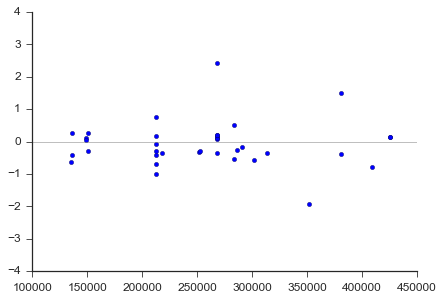

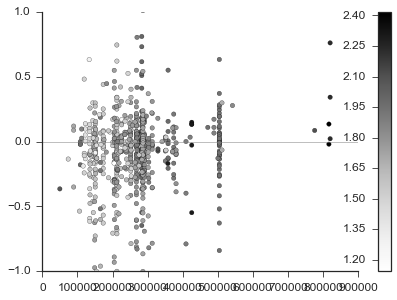

In [35]:
plt.figure()
plt.scatter(d['NBS'][d['NBS']['c_hyp'] == True]['latest_zhvi'], d['NBS'][d['NBS']['c_hyp'] == True]['slope'])
plt.ylim(-4.0,4.0)
plt.axhline(0, c = 'grey', lw = 0.5)
sns.despine()

plt.figure()
plt.scatter(d['NBS']['latest_zhvi'], d['NBS']['slope'], c = d['NBS']['mean_price'])
plt.colorbar()
plt.ylim(-1.0,1.0)
plt.axhline(0, c = 'grey', lw = 0.5)
sns.despine()

In [36]:
pos_bus = d['NBS'][(d['NBS']['c_hyp'] == True) & (d['NBS']['slope'] > 0)].dropna( axis = 1, how = 'all')
neg_bus = d['NBS'][(d['NBS']['c_hyp'] == True) & (d['NBS']['slope'] < 0)].dropna( axis = 1, how = 'all')

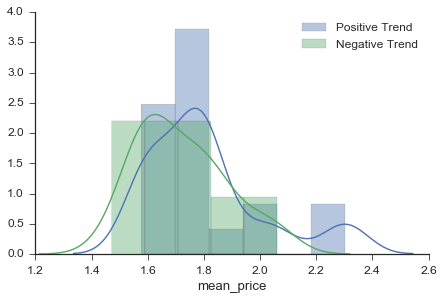

In [40]:
sns.distplot(pos_bus['mean_price'], label = 'Positive Trend')
sns.distplot(neg_bus['mean_price'], label = 'Negative Trend')
plt.legend()
sns.despine()

In [127]:
pd.DataFrame(columns = {'z_hood': np.unique(neg_bus['z_hood'], return_counts = True)[0],\
            'counts': np.unique(neg_bus['z_hood'], return_counts = True)[1]})

,counts,z_hood


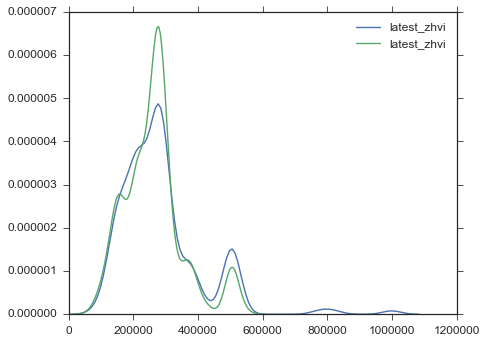

In [116]:
sns.kdeplot(pos_bus['latest_zhvi'].dropna())
sns.kdeplot(neg_bus['latest_zhvi'].dropna())

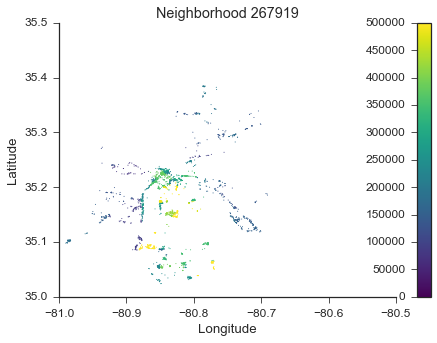

In [102]:
pylab.rcParams['figure.figsize'] = (7.0, 5.0) #use a bigger figure size for this data map

'''
b = d['NBS']
plt.figure()
plt.title('Neighborhood ' + str(list(b['z_hood'])[0]))
plt.scatter(b['longitude'], b['latitude'], c = b['latest_zhvi'], cmap = 'viridis', norm = mpl.colors.Normalize(0,500000), lw = 0, s = 1)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-112.5, -111.4)
plt.ylim(33.2,33.9)
sns.despine()
'''

pylab.rcParams['figure.figsize'] = (7.0, 5.0) #use a bigger figure size for this data map
b = d['NBS']
plt.figure()
plt.title('Neighborhood ' + str(list(b['z_hood'])[0]))
plt.scatter(b['longitude'], b['latitude'], c = b['latest_zhvi'], cmap = 'viridis', norm = mpl.colors.Normalize(0,500000), lw = 0, s = 1)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(35,35.5)
plt.xlim(-81, -80.5)
sns.despine()

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


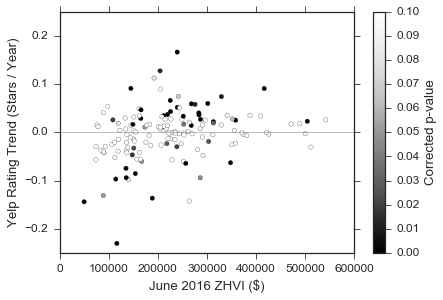

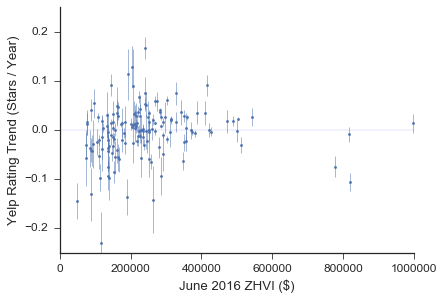

In [15]:
plt.figure()
plt.scatter(d['NS']['latest_zhvi'], \
            d['NS']['slope'],\
           c = d['NS']['c_pvals'],\
           cmap = 'Greys_r', norm = mpl.colors.Normalize(0.0, 0.10))
plt.colorbar(label = 'Corrected p-value')
plt.axhline(0, lw = 0.5, c = 'grey')
plt.ylim(-0.25,0.25)
plt.xlim(0,600000)
#sns.despine()
plt.ylabel('Yelp Rating Trend (Stars / Year)')
plt.xlabel('June 2016 ZHVI ($)')
plt.savefig('ratings_trend_pval.png', fmt = 'png', dpi = 300)


plt.figure()
plt.errorbar(d['NS']['latest_zhvi'], \
            d['NS']['slope'], d['NS']['slope_err'], fmt = '.', lw = 0.5)
plt.axhline(0, lw = 0.1)
plt.ylim(-0.25,0.25)
sns.despine()
plt.ylabel('Yelp Rating Trend (Stars / Year)')
plt.xlabel('June 2016 ZHVI ($)')
plt.savefig('ratings_trend_error.png', fmt = 'png', dpi = 300)

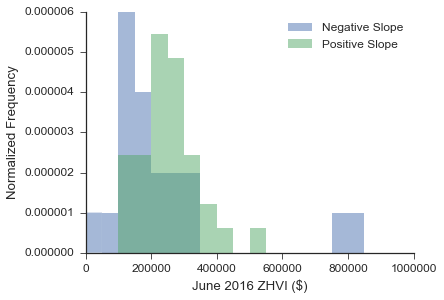

In [42]:
plt.hist(d['NS'][(d['NS']['c_hyp'] == True) & (d['NS']['slope'] < 0)]['latest_zhvi'],\
         normed = True, range = [0,1000000], lw = 0, bins = 20, alpha = 0.5, label = 'Negative Slope')
plt.hist(d['NS'][(d['NS']['c_hyp'] == True) & (d['NS']['slope'] > 0)]['latest_zhvi'],\
         normed = True, range = [0,1000000], lw = 0, bins = 20, alpha = 0.5, label = 'Positive Slope')
sns.despine()
plt.legend()
plt.xlabel('June 2016 ZHVI ($)')
plt.ylabel('Normalized Frequency')
plt.savefig('ratings_trend_hist.png', fmt = 'png', dpi = 300)

In [18]:
len(d['NS'][(d['NS']['c_hyp'] == True) & (d['NS']['slope'] < 0)])
len(d['NS'][(d['NS']['c_hyp'] == True) & (d['NS']['slope'] > 0)])

33

(-0.2, 0.2)

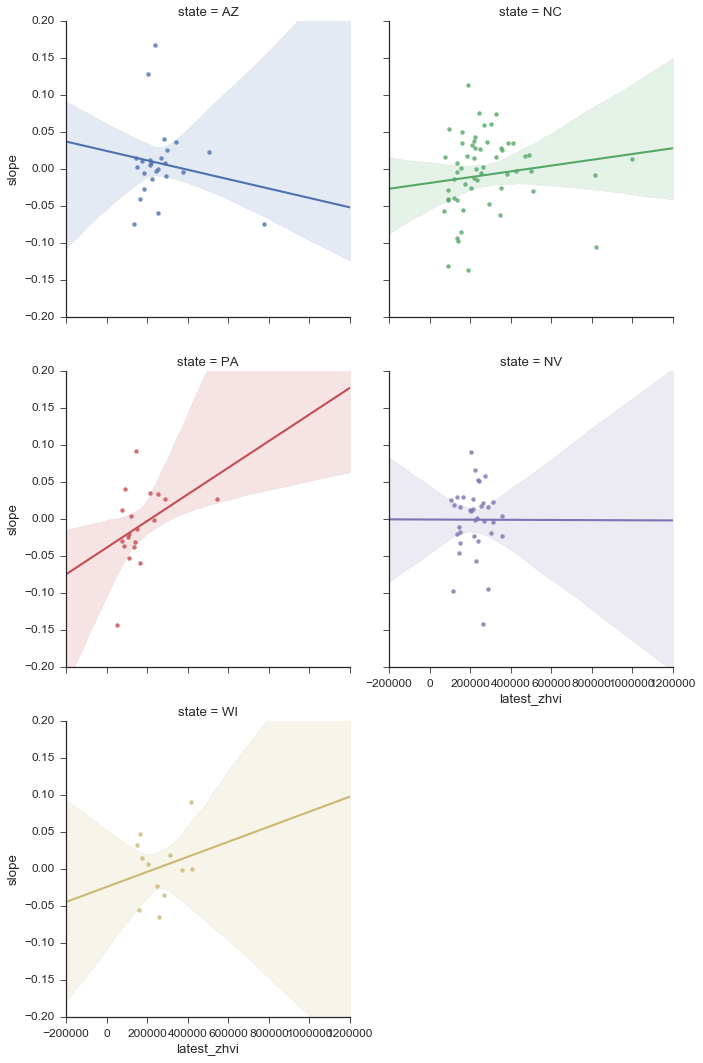

In [48]:
sns.lmplot(data = d['NS'], x = 'latest_zhvi', y = 'slope',\
           hue = 'state', col = 'state', fit_reg = True, col_wrap = 2)
plt.ylim(-0.2,0.2)
#plt.xlim(0,800000)

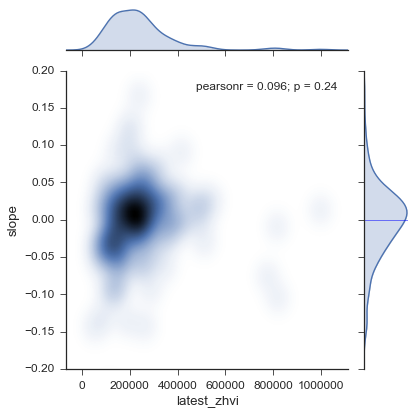

In [299]:
sns.jointplot(data = d['NS'], x = 'latest_zhvi', y = 'slope', kind = 'kde', shade = True, n_levels = 300)
plt.ylim(-0.2,0.2)

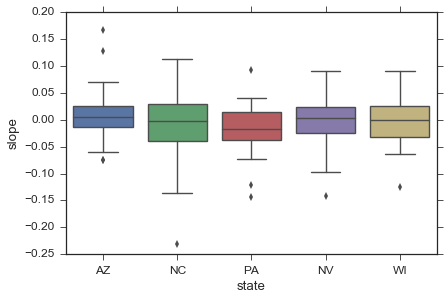

In [242]:
sns.boxplot(data = d['NS'], x = 'state', y = 'slope')

 # Start Timeseries Cross Correlation

In [9]:
zhvi = pd.read_csv('Normalized_Neighborhood_Zhvi_AllHomes.csv') #normalized zhvi values

In [ ]:
#normalize rating_ts
mean_1 = (rating_ts.mean(axis = 1))

for column in rating_ts.columns: #average the time series
    rating_ts[column] = rating_ts[column] / mean_1

mean_2 = rating_ts.mean(axis = 0) #sum down the rows

for column in rating_ts.columns[:-2]: #average the time series the other way
    rating_ts[column] = rating_ts[column] / mean_2[column]

In [13]:
print (range(4))

[0, 1, 2, 3]


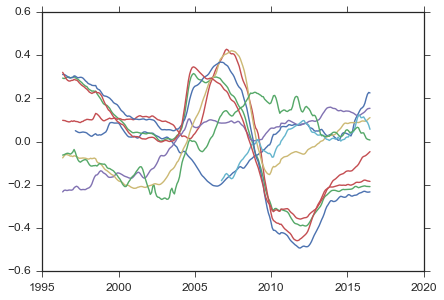

In [234]:
for i in range(1,10):
    plt.plot(zhvi['time'], zhvi[zhvi.columns[i]] - 1.0)

In [532]:
def HendersonFilter(df, y):
    
    df.index = range(len(df)) #reindex dataframe
    
    w = defaultdict(lambda : [-0.07343, 0.29371, 0.55944, 0.29371, -0.07343]) #initialize all middle weights
    
    #Henderson Filter Weights
    w[1] = (0, 0, 0.76467, 0.36713, -0.13181) # starting point
    w[2] = (0, 0.22776, 0.52522, 0.29121,-0.04419) # second point
    w[len(df) - 2] = (-0.04419, 0.29121, 0.52522, 0.22776, 0) # T_max
    w[len(df) - 1] = (-0.13181, 0.36713, 0.76467, 0, 0) # T_max - 1
    
    filtered = []
    
    for i in range(len(df)):
        if i == 0:
            filtered.append(np.dot(w[i], df[y][:5]))
        elif i == 1:
            filtered.append(np.dot(w[i], df[y][:5]))
        elif i == (len(df) - 2):
            filtered.append(np.dot(w[i], df[y][-5:]))
        elif i == (len(df) - 1):
            filtered.append(np.dot(w[i], df[y][-5:]))
        else:
            filtered.append(np.dot(w[i], df[y][i-2:i+3]))
            
    df.loc[:,('fy')] = filtered
            
    return df

In [533]:
df = rating_ts[['time','112345_0']]

In [534]:
f_df = HendersonFilter(df, '112345_0')

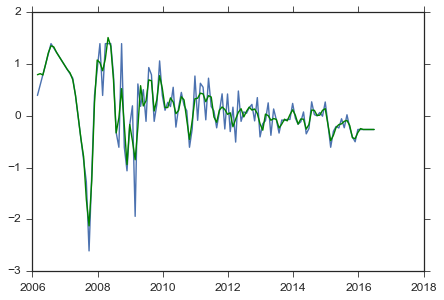

In [539]:
plt.plot(f_df['time'], f_df['112345_0'])
plt.plot(f_df['time'], f_df['fy'], c = 'green')

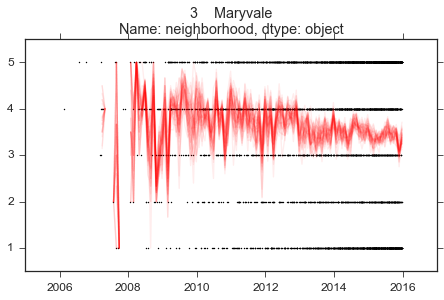

In [488]:
rating_ts = pd.DataFrame()
n_samples = 40

for ids in np.unique(d['N']['z_hood'][2:3]): #for the unique business IDs, i.e. for each neighborhood
    
    r = d['R'][d['R']['z_hood'] == ids][['year','stars']] #create a review dataframe that is just for that neighborhood
    r.index = range(len(r)) #reindex the review dataframe
    
    plt.figure()
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black') #plot all of the reviews as black lines
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.ylim(0.5,5.5)
    plt.xlim(2005, 2017)
    
    for n in range(n_samples):
        b = BootstrapDataframe(r) #bootstrap resample the dataframe
        bm, bc, _ = scipy.stats.binned_statistic(b['year'], b['stars'], statistic = 'mean', bins = 243, range = [1996.24476353,2016.480375])
        bc = bc[1:] #remove the first bin edge, since the statistic is compiled at the end of the month
        gm = pd.DataFrame({'t': zhvi['time'], 'y': bm}) #create a dataframe of the binned mean
        plt.plot(gm['t'], gm['y'], c = 'red', alpha = 0.07) #plot the trace
        rating_ts[str(ids) + '_' + str(n)] = gm['y'].interpolate() #append the y-values to the dataframe
    
    rating_ts['time'] = zhvi['time'] #create year column
    rating_ts = rating_ts[(rating_ts['time'] >= min(r['year'])) & (rating_ts['time'] <= max(zhvi[[str(ids), 'time']].dropna()['time'])) & (rating_ts['time'] >= min(zhvi[[str(ids), 'time']].dropna()['time']))] #limit to where we have zillow data
    
    #normalize the time series by subtracting the average
    bs_mean = np.mean(np.ravel(rating_ts[rating_ts.columns[:-1]].dropna().as_matrix())) #mean of bootstrapped means

    for column in rating_ts.columns[:-1]: #exclude the final year column
        rating_ts[column] = rating_ts[column] - bs_mean #subtract the mean rating in stars
        
    intersect_columns = rating_ts.columns[1][0:6] #find the z_hood identifier for the neighborhood in question
    
    #merge the rating_ts and zhvi dataframes into a correlation dataframe
    cor_df = pd.merge(rating_ts, zhvi[[intersect_columns, 'time']], on = 'time') #merge zhvi with yelp on time column
    cor_df.rename(columns = {intersect_columns : 'z'}, inplace = True) #rename the zillow time-series 'z'

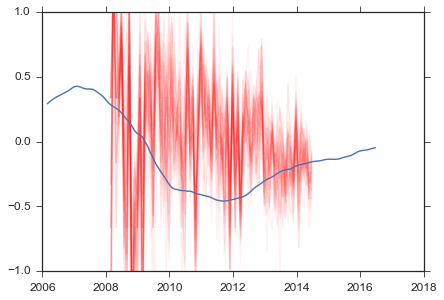

In [474]:
n_months = 24

for sim in cor_df.columns[:-2]:
    cor_df[sim][:n_months] = np.nan
    cor_df[sim][-n_months:] = np.nan
    
shifts = np.arange(-n_months,n_months + 1)
power = defaultdict(list)

for sim in cor_df.columns[:-2]:
    plt.plot(cor_df['time'], cor_df[sim], c = 'red', alpha = 0.05)
plt.plot(cor_df['time'], cor_df['z'] - 1.0)
plt.ylim(-1.0, 1.0)

for sim in cor_df.columns[:-2]:
    for s in shifts:
        shift_df = pd.DataFrame()
        grad_df = pd.DataFrame()
        shift_df['z'] = cor_df['z']
        shift_df['y'] = cor_df[sim].shift(s)
        shift_df = shift_df.dropna()
        grad_df = shift_df.apply(np.gradient) #df of gradients
        #grad_df = grad_df.dropna()
        power[s].append(np.correlate(grad_df['z'], grad_df['y'])[0])

In [475]:
power = pd.DataFrame(power)
power['z_hood'] = intersect_columns

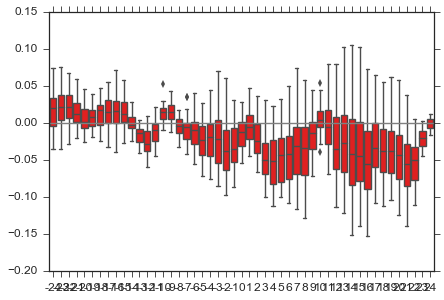

In [476]:
sns.boxplot(power.drop(['z_hood'], axis = 1), color = 'red')
plt.axhline(0, c = 'grey')
#plt.axvline(0, c = 'grey')

In [123]:
#intersect_columns = list(set(rating_ts.columns) & set(zhvi.columns)) #find the columns in both ratings and zhvi
#intersect_columns.remove('time') #remove time column

In [58]:
print(len(zhvi.columns))
print(len(rating_ts.columns))
print(len(intersect_columns))

5925
11
10


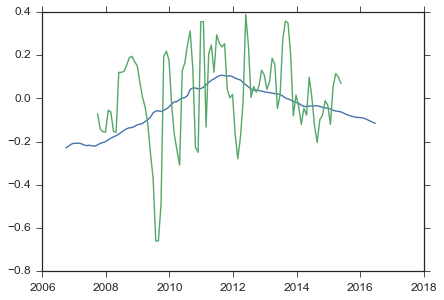

In [68]:
n_months = 12

for hood in intersect_columns[0:1]:
    cor_df = pd.merge(zhvi[zhvi['time'] >= (min_t[hood])][[hood, 'time']], rating_ts[(rating_ts['time'] >= (min_t[hood] + n_months/12.0)) & (rating_ts['time'] <= max(rating_ts['time'] - n_months/12.0))][[hood, 'time']], on = 'time', how = 'outer')
    cor_df.rename(columns = {hood + '_x': 'z', hood + '_y': 'y'}, inplace = True)
    cor_df.sort_values(by = 'time', axis = 0, inplace = True)
    cor_df.index = range(len(cor_df))
    
    plt.plot(cor_df['time'],cor_df['z'] - 1.0)
    plt.plot(cor_df['time'],cor_df['y'].shift(0))
    
shifts = np.arange(-n_months,n_months)
power = []

for s in shifts:
    shift_df = pd.DataFrame()
    shift_df['z'] = cor_df['z']
    shift_df['y'] = cor_df['y'].shift(s)
    shift_df = shift_df.dropna()
    power.append(np.correlate(shift_df['z'] - 1.0, shift_df['y']))

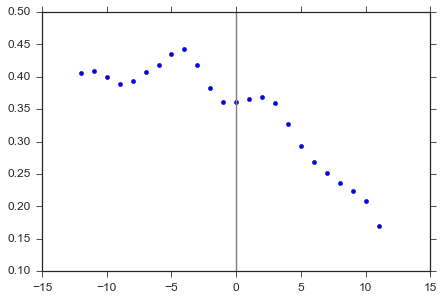

In [69]:
plt.scatter(shifts, power)
plt.axvline(0, c = 'grey')

 ## Find a Gaussian Kernel to Match the Henderson Filter

In [59]:
henderson_x = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])/12.0
henderson_y = np.array([-0.07343, 0.29371, 0.55944, 0.29371, -0.07343])

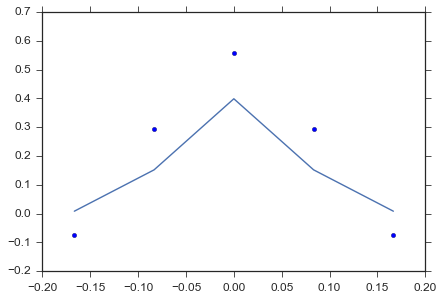

In [76]:
plt.scatter(henderson_x, henderson_y)
plt.plot(henderson_x, scipy.stats.norm.pdf(henderson_x/0.06))